In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !pip install pyedflib -q

In [3]:
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from eeg_util_pt2 import get_pickled_data, construct_timesteps

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, CuDNNLSTM, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K

In [4]:
ref_dict_folder = "/content/drive/My Drive/Insight/pickle_ref_dict/"
paths = sorted(glob.glob(f"{ref_dict_folder}*ref_dict.pickle"))

for path in paths:
    subject = path.split("/")[-1].split(".")[0]
    with open(path, "rb") as f:
        ref_dict = pickle.load(f)
        events = 0
        for key, value in ref_dict.items():
            if "seg" not in key:
                events += len(value)
    if events > 7:
        print(subject, events)

chb06_ref_dict 10
chb12_ref_dict 27
chb13_ref_dict 12
chb14_ref_dict 8
chb15_ref_dict 20
chb16_ref_dict 10
chb20_ref_dict 8
chb24_ref_dict 16


In [13]:
preictal_length = 16
train_ids = [6]
power, label = get_pickled_data(train_ids, preictal_length, clean_spectra=True, threshold=-25, z_score=True)

power.shape, label.shape, (label==0).sum(), (label==1).sum(), (label==2).sum()

((60060, 90), (60060,), 59972, 40, 48)

In [14]:
# "4 sec" is segment length
preictal_starts = np.where(label==1)[0][::(preictal_length//4)]
# use last 3 seizure episodes for testing, all previous for training
testing_episodes = 5
cutoff_idx = np.where(label==1)[0][::(preictal_length//4)][-testing_episodes]
assert label[cutoff_idx-20:cutoff_idx].sum() == 0

train_X, train_y = power[:cutoff_idx-20], label[:cutoff_idx-20]
test_X, test_y = power[cutoff_idx-20:], label[cutoff_idx-20:]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((31622, 90), (31622,), (28438, 90), (28438,))

In [15]:
Tx = 2

# construct_timesteps return [binned_X, binned_y] for given label
train_data = [construct_timesteps(train_X, train_y, label=i, Tx=2, num_interictal=500) for i in range(3)]
train_X = np.concatenate([lst[0] for lst in train_data], axis=0)
train_y = np.concatenate([lst[1] for lst in train_data], axis=0)

test_data = [construct_timesteps(test_X, test_y, label=i, Tx=2, num_interictal=100) for i in range(3)]
test_X = np.concatenate([lst[0] for lst in test_data], axis=0)
test_y = np.concatenate([lst[1] for lst in test_data], axis=0)

# shuffle segments
np.random.seed(3)
train_order = np.random.permutation(len(train_y))
train_X, train_y = train_X[train_order], train_y[train_order]

np.random.seed(5)
test_order = np.random.permutation(len(test_y))
test_X, test_y = test_X[test_order], test_y[test_order]

for i in range(3):
    print(f"train label {i}: {(train_y==i).sum()}")
for i in range(3):
    print(f"test label {i}: {(test_y==i).sum()}")


train_X.shape, train_y.shape, test_X.shape, test_y.shape

train label 0: 500
train label 1: 15
train label 2: 21
test label 0: 100
test label 1: 15
test label 2: 17


((536, 2, 90), (536,), (132, 2, 90), (132,))

In [0]:
def LSTM_model(Tx: int):
    
    X_input = Input(shape=(Tx, 90))
    X = X_input

    X = Bidirectional(CuDNNLSTM(64))(X)
    X = Dropout(0.25)(X)
    X = BatchNormalization()(X)
    
    X = Dense(64, activation="relu")(X)
    X = Dropout(0.25)(X)
    X = BatchNormalization()(X)
    
    output = Dense(3, activation="softmax")(X)

    model = Model(inputs=X_input, outputs=output)
    
    return model

In [17]:
K.clear_session()

lstm_clf = LSTM_model(Tx=Tx)
lstm_clf.summary()

train_y_OH = np.eye(3)[train_y]
test_y_OH = np.eye(3)[test_y]

opt=Adam(lr=1e-3)

lr_reduction = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2, 
        patience=10, 
        verbose=1,
        min_delta=1e-4,
        cooldown=0,
        min_lr=1e-7
    )

lstm_clf.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 90)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               79872     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256   

In [18]:
weights = compute_class_weight("balanced", [0,1,2], train_y)

history = lstm_clf.fit(
    train_X,
    train_y_OH,
    validation_data=(test_X, test_y_OH),
    batch_size=32,
    epochs=20,
    class_weight=weights,
    callbacks=[lr_reduction],
    verbose=1,
)

Train on 536 samples, validate on 132 samples
Epoch 1/20
536/536 [==============================] - 6s 11ms/sample - loss: 1.3768 - acc: 0.3787 - val_loss: 0.9697 - val_acc: 0.7424
Epoch 2/20
536/536 [==============================] - 0s 208us/sample - loss: 1.0999 - acc: 0.4608 - val_loss: 0.9293 - val_acc: 0.8106
Epoch 3/20
536/536 [==============================] - 0s 215us/sample - loss: 0.9303 - acc: 0.5410 - val_loss: 0.8705 - val_acc: 0.8409
Epoch 4/20
536/536 [==============================] - 0s 198us/sample - loss: 0.8138 - acc: 0.6530 - val_loss: 0.8353 - val_acc: 0.8485
Epoch 5/20
536/536 [==============================] - 0s 225us/sample - loss: 0.7000 - acc: 0.7481 - val_loss: 0.7471 - val_acc: 0.8712
Epoch 6/20
536/536 [==============================] - 0s 204us/sample - loss: 0.5859 - acc: 0.8004 - val_loss: 0.6799 - val_acc: 0.8636
Epoch 7/20
536/536 [==============================] - 0s 203us/sample - loss: 0.5003 - acc: 0.8451 - val_loss: 0.6175 - val_acc: 0.8636
Epo

[Text(0.5, 1.0, 'acc')]

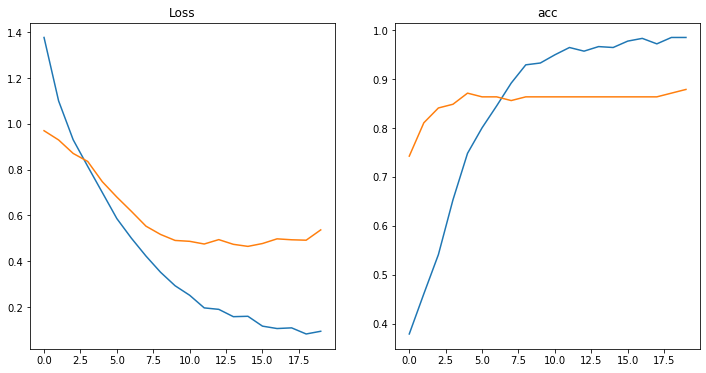

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.set(title="Loss")

ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.set(title="acc")


              precision    recall  f1-score   support

  interictal       0.86      1.00      0.93       100
    preictal       0.00      0.00      0.00        15
       ictal       1.00      0.94      0.97        17

    accuracy                           0.88       132
   macro avg       0.62      0.65      0.63       132
weighted avg       0.78      0.88      0.83       132



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


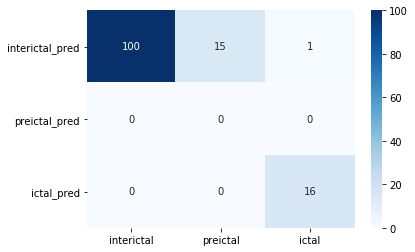

In [20]:
prediction = lstm_clf.predict(test_X)

confusion = confusion_matrix(test_y, prediction.argmax(-1))
report = classification_report(test_y, prediction.argmax(-1), labels=[0,1,2], target_names=["interictal", "preictal", "ictal"])

print(report)

sns.heatmap(
    confusion.T, 
    cmap="Blues", 
    annot=True, 
    fmt="d", 
    xticklabels=["interictal", "preictal", "ictal"], 
    yticklabels=["interictal_pred", "preictal_pred", "ictal_pred"]
)